In [86]:
%reload_ext autoreload
%autoreload 2

import os
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import label_binarize

from MAPIE.mapie.metrics import classification_coverage_score, classification_ssc
from MAPIE.mapie.classification import MapieClassifier

In [87]:
PATH_DINO = './dino_data/'
ALPHAS = np.arange(0, 1, .1)

In [88]:
train_set = np.load(os.path.join(PATH_DINO, 'train.npy'))
res_set = np.load(os.path.join(PATH_DINO, 'res.npy'))
cal_set = np.load(os.path.join(PATH_DINO, 'cal.npy'))
test_original_set = np.load(os.path.join(PATH_DINO, 'test_original.npy'))
test_noise_set = np.load(os.path.join(PATH_DINO, 'test_noise.npy'))

In [89]:
X_train_emb, y_train = train_set[:, :-1], train_set[:, -1]
X_res_emb, y_res = res_set[:, :-1], res_set[:, -1]
X_cal_loss, X_cal_emb, y_cal = cal_set[:, 0], cal_set[:, 1:-1], cal_set[:, -1]
X_test_original_loss, X_test_original_emb, y_test = test_original_set[:, 0], test_original_set[:, 1:-1], test_original_set[:, -1]
X_test_noise_loss, X_test_noise_emb, _ = test_noise_set[:, 0], test_noise_set[:, 1:-1], test_noise_set[:, -1]

# Utils functions

In [90]:
class MapieWrapper:
    def __init__(self, model=None):
        self.model = model
        self.trained_ = True
        self.classes_ = np.arange(1000)

    def fit(self, X, y=None):
        pass

    def predict_proba(self, X):
        if self.model:
            X_test = torch.tensor(X, dtype=torch.float32)

            self.model.eval()

            with torch.no_grad():
                outputs = self.model(X_test)

            proba = nn.functional.softmax(outputs, dim=1).numpy()
            return proba
        else:
            return X

    def predict(self, X):
        pred_proba = self.predict_proba(X)
        pred = np.argmax(pred_proba, axis=1)
        return pred

    def __sklearn_is_fitted__(self):
        return True
    
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))
    return [correct[:k].reshape(-1).float().sum(0) * 100.0 / batch_size for k in topk]

def count_null_set(y):
    count = 0
    for pred in y[:, :]:
        if np.sum(pred) == 0:
            count += 1
    return count

def _get_true_label_cumsum_proba(
    y,
    y_pred_proba,
):
    y_true = label_binarize(y=y, classes=range(1000))
    index_sorted = np.fliplr(np.argsort(y_pred_proba, axis=1))
    y_pred_proba_sorted = np.take_along_axis(y_pred_proba, index_sorted, axis=1)
    y_true_sorted = np.take_along_axis(y_true, index_sorted, axis=1)
    y_pred_proba_sorted_cumsum = np.cumsum(y_pred_proba_sorted, axis=1)
    cutoff = np.argmax(y_true_sorted, axis=1)
    true_label_cumsum_proba = np.take_along_axis(
        y_pred_proba_sorted_cumsum, cutoff.reshape(-1, 1), axis=1
    )
    return true_label_cumsum_proba, cutoff + 1

def get_residuals(y_res, y_pred_proba, method):
    if method == "crf_score":
        y_res_predict_new = np.take_along_axis(
            1 - y_pred_proba, np.expand_dims(y_res, axis=1), axis=1
        )
    elif method == "crf_aps":
        cum_sum_proba = _get_true_label_cumsum_proba(y=y_res, y_pred_proba=y_pred_proba)
        y_res_predict_new = cum_sum_proba[0].ravel()[:, np.newaxis]
    return y_res_predict_new

class LinearRegressor(nn.Module):
    def __init__(self, in_dim) -> None:
        super().__init__()
        self.in_dim = in_dim
        self.layer1 = nn.Linear(self.in_dim, 1000)
        self.layer2 = nn.Linear(1000, 32)
        self.layer5 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, X):
        out = self.relu(self.layer1(X))
        out = self.relu(self.layer2(out))
        # out = self.relu(self.layer3(out))
        # out = self.relu(self.layer4(out))
        out = self.relu(self.layer5(out))
        return out


class LinearClassifier(nn.Module):
    """Linear layer to train on top of frozen features"""

    def __init__(self, dim, num_labels=1000):
        super().__init__()
        self.num_labels = num_labels
        self.linear = nn.Linear(dim, num_labels)
        self.linear.weight.data.normal_(mean=0.0, std=0.01)
        self.linear.bias.data.zero_()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.linear(x)


def train_classifier(
    model, train_loader, val_loader, optimizer, scheduler, criterion, n_epochs
):
    for epoch in range(n_epochs):
        model.train()
        running_loss = []
        for input, label in train_loader:
            output = model(input)
            loss = criterion(output, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss.append(loss.item())

        train_loss = np.mean(running_loss)

        model.eval()
        running_loss = []
        for input, label in val_loader:
            output = model(input)
            loss = criterion(output, label)
            if model.num_labels >= 5:
                acc1, acc5 = accuracy(output, label, topk=(1, 5))
            else:
                (acc1,) = accuracy(output, label, topk=(1,))

            running_loss.append(loss.item())

        eval_loss = np.mean(running_loss)

        print(
            f"Epoch {epoch+1}/{n_epochs}, Train loss: {train_loss:.4f}, Eval loss: {eval_loss:.4f}, Acc@1: {acc1:.3f}"
        )

        scheduler.step()


def train_regressor(
    model, train_loader, val_loader, optimizer, scheduler, criterion, n_epochs
):
    for epoch in range(n_epochs):
        model.train()
        running_loss = []
        for input, target in train_loader:
            output = model(input)
            loss = torch.sqrt(
                criterion(output.to(torch.float32), target.to(torch.float32))
            )
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss.append(loss.item())
        train_loss = np.mean(running_loss)

        model.eval()
        running_loss = []
        for input, target in val_loader:
            output = model(input)
            loss = torch.sqrt(
                criterion(output.to(torch.float32), target.to(torch.float32))
            )

            running_loss.append(loss.item())

        eval_loss = np.mean(running_loss)

        print(
            f"Epoch {epoch+1}/{n_epochs}, Train loss: {train_loss:.4f}, Eval loss: {eval_loss:.4f}"
        )

## Pytorch Model

In [91]:
BATCH_SIZE = 512
EMBED_DIM = 384
EPOCHS = 100

In [92]:
train_x, val_x, train_y, val_y = train_test_split(torch.Tensor(X_train_emb), torch.Tensor(y_train).type(torch.LongTensor), train_size=.8)

train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

#### KNN Classifier

In [93]:
knn_classifier = KNeighborsClassifier(n_neighbors=8)
knn_classifier.fit(X_train_emb, y_train)

KNeighborsClassifier(n_neighbors=8)

#### Linear Classifier

In [94]:
linear_classifier = LinearClassifier(dim=EMBED_DIM, num_labels=1000)

clf_optimizer = torch.optim.SGD(linear_classifier.parameters(), lr=0.001, momentum=0.9, weight_decay=0)
clf_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(clf_optimizer, EPOCHS, eta_min=0)
clf_criterion = nn.CrossEntropyLoss()

train_classifier(linear_classifier, train_loader, val_loader, clf_optimizer, clf_scheduler, clf_criterion, 50)

Epoch 1/50, Train loss: 6.8055, Eval loss: 6.2034, Acc@1: 3.261
Epoch 2/50, Train loss: 5.4867, Eval loss: 5.0073, Acc@1: 30.978
Epoch 3/50, Train loss: 4.2539, Eval loss: 3.9781, Acc@1: 43.478
Epoch 4/50, Train loss: 3.2667, Eval loss: 3.1944, Acc@1: 52.446
Epoch 5/50, Train loss: 2.5632, Eval loss: 2.6442, Acc@1: 60.054
Epoch 6/50, Train loss: 2.0861, Eval loss: 2.2693, Acc@1: 62.500
Epoch 7/50, Train loss: 1.7616, Eval loss: 2.0124, Acc@1: 64.402
Epoch 8/50, Train loss: 1.5340, Eval loss: 1.8319, Acc@1: 65.217
Epoch 9/50, Train loss: 1.3681, Eval loss: 1.7010, Acc@1: 68.478
Epoch 10/50, Train loss: 1.2423, Eval loss: 1.6032, Acc@1: 70.380
Epoch 11/50, Train loss: 1.1437, Eval loss: 1.5281, Acc@1: 70.924
Epoch 12/50, Train loss: 1.0639, Eval loss: 1.4689, Acc@1: 72.283
Epoch 13/50, Train loss: 0.9976, Eval loss: 1.4213, Acc@1: 73.098
Epoch 14/50, Train loss: 0.9414, Eval loss: 1.3822, Acc@1: 73.370
Epoch 15/50, Train loss: 0.8929, Eval loss: 1.3496, Acc@1: 73.641
Epoch 16/50, Train l

# Residual Predictor

In [95]:
y_res_softmax = nn.functional.softmax(linear_classifier(torch.Tensor(X_res_emb)))
y_res_fit = get_residuals(y_res=torch.Tensor(y_res).type(torch.LongTensor).tolist(), y_pred_proba=y_res_softmax, method='crf_score')

In [96]:
train_res_x, val_res_x, train_res_y, val_res_y = train_test_split(torch.Tensor(X_res_emb), y_res_fit, train_size=.9)

train_res_dataset = TensorDataset(train_res_x, train_res_y)
val_res_dataset = TensorDataset(val_res_x, val_res_y)

train_res_loader = DataLoader(train_dataset, batch_size=1024)
val_res_loader = DataLoader(val_dataset, batch_size=1024)

In [97]:
knn_regressor = KNeighborsRegressor()

param_grid = {
    'n_neighbors': [5, 6, 7, 8, 9, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
}

grid_search = GridSearchCV(knn_regressor, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_res_emb, y_res_fit.detach().numpy())

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Negative Mean Squared Error:", -grid_search.best_score_)

Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'}
Best Negative Mean Squared Error: 0.10739037688922988


In [98]:
knn_regressor = KNeighborsRegressor(metric='manhattan', weights='distance', n_neighbors=6).fit(X_res_emb, y_res_fit.detach().numpy())

In [99]:
# residual_regressor = LinearRegressor(in_dim=384)

# regr_optimizer = torch.optim.SGD(residual_regressor.parameters(), lr=0.001, weight_decay=0)
# regr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(regr_optimizer, EPOCHS)
# regr_criterion = nn.MSELoss()

# train_regressor(residual_regressor, train_res_loader, val_res_loader, regr_optimizer, regr_scheduler, regr_criterion, 100)

# Conformal Classifier

In [100]:
method_params = {
    "SCORE": ("score", True),
    "APS": ("cumulated_score", True),
    "RAPS": ("raps", True),
    "CRF-APS": ("crf_aps", True),
    "Penalized-APS": ("ssaps", True),
    "SSCP": ("ssaps", True)
}

ALPHAS = np.arange(0.1, 1, .1)

### Check models accuracy

In [101]:
y_test_preds = MapieWrapper(linear_classifier).predict(X_test_original_emb)
test_linear_original_accuracy = accuracy_score(y_test, y_test_preds)

y_test_preds = MapieWrapper(linear_classifier).predict(X_test_noise_emb)
test_linear_noise_accuracy = accuracy_score(y_test, y_test_preds)

test_knn_original_accuracy = accuracy_score(y_test, knn_classifier.predict(X_test_original_emb))
test_knn_noise_accuracy = accuracy_score(y_test, knn_classifier.predict(X_test_noise_emb))

results = {
    'Model': ['Linear', 'K-NN'],
    'Original Images': [test_linear_original_accuracy, test_knn_original_accuracy],
    'Perturbated Images': [test_linear_noise_accuracy, test_knn_noise_accuracy]
}

df = pd.DataFrame(results)
df.set_index('Model', inplace=False)
df

,Model,Original Images,Perturbated Images
0,Linear,0.723600,0.697733
1,K-NN,0.690133,0.672267


### Predict sets

In [102]:
preds_dict, pss_dict, cal_conformity_scores = {}, {}, {}
mapie_model = MapieWrapper(linear_classifier)
cal_residuals_preds = knn_regressor.predict(X_cal_emb)[:, 0]
test_residuals_preds = knn_regressor.predict(X_test_original_emb)[:, 0]
for method_name, (method, include_last_label) in method_params.items():
    mapie = MapieClassifier(
        mapie_model, method=method, cv="prefit", random_state=1
    )
    if method_name in ['CRF-SCORE', 'CRF-APS', 'Penalized-APS']:
        mapie.fit(X_cal_emb, y_cal, residuals=cal_residuals_preds)
        cal_conformity_scores[method_name] = mapie.conformity_scores_
        (
            preds_dict[method_name],
            pss_dict[method_name],
        ) = mapie.predict(
            X_test_original_emb,
            alpha=ALPHAS,
            include_last_label=include_last_label,
            residuals=test_residuals_preds,
        )
    elif method_name == 'SSCP':
        mapie.fit(X_cal_emb, y_cal, residuals=X_cal_loss)
        cal_conformity_scores[method_name] = mapie.conformity_scores_
        (
            preds_dict[method_name],
            pss_dict[method_name],
        ) = mapie.predict(
            X_test_original_emb,
            alpha=ALPHAS,
            include_last_label=include_last_label,
            residuals=X_test_original_loss,
        )
    else:
        mapie.fit(X_cal_emb, y_cal)
        cal_conformity_scores[method_name] = mapie.conformity_scores_
        (
            preds_dict[method_name],
            pss_dict[method_name],
        ) = mapie.predict(
            X_test_original_emb,
            alpha=ALPHAS,
            include_last_label=include_last_label
        )

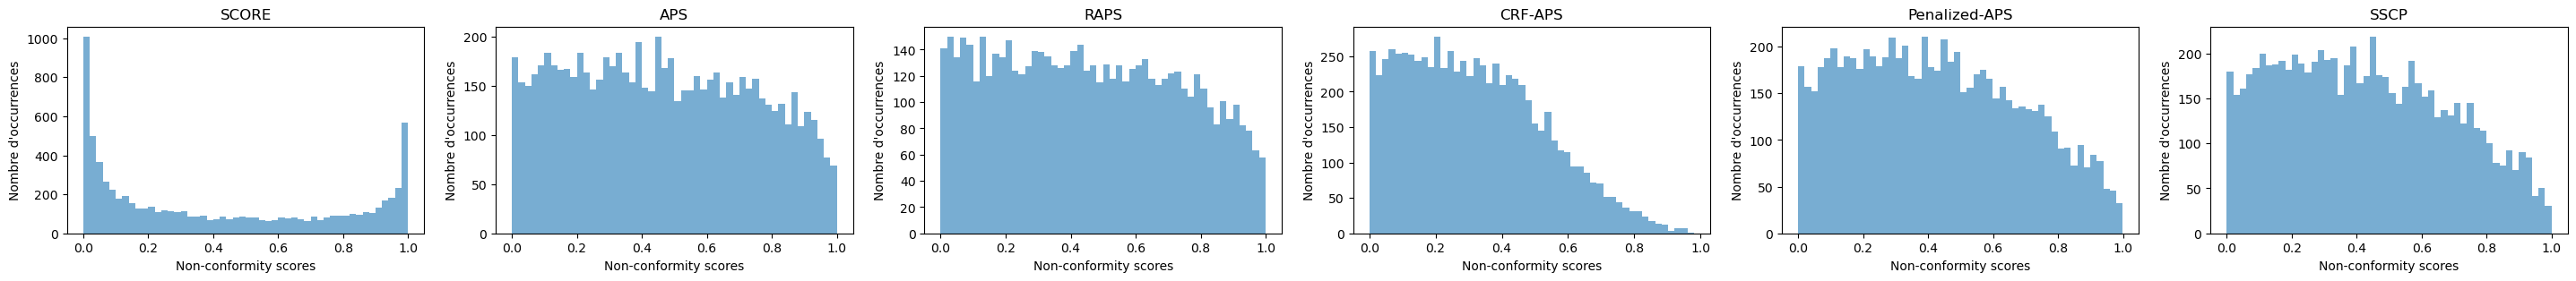

In [103]:
fig, axs = plt.subplots(1, len(method_params), figsize=(6 * len(method_params), 3))
for i, (method, predictions) in enumerate(pss_dict.items()):
    axs[i].hist(cal_conformity_scores[method], bins=50, alpha=0.6, label=method)
    axs[i].set_xlabel("Non-conformity scores")
    axs[i].set_ylabel("Nombre d'occurrences")
    axs[i].set_title(method)

### Couverture marginale et taille moyenne des ensembles

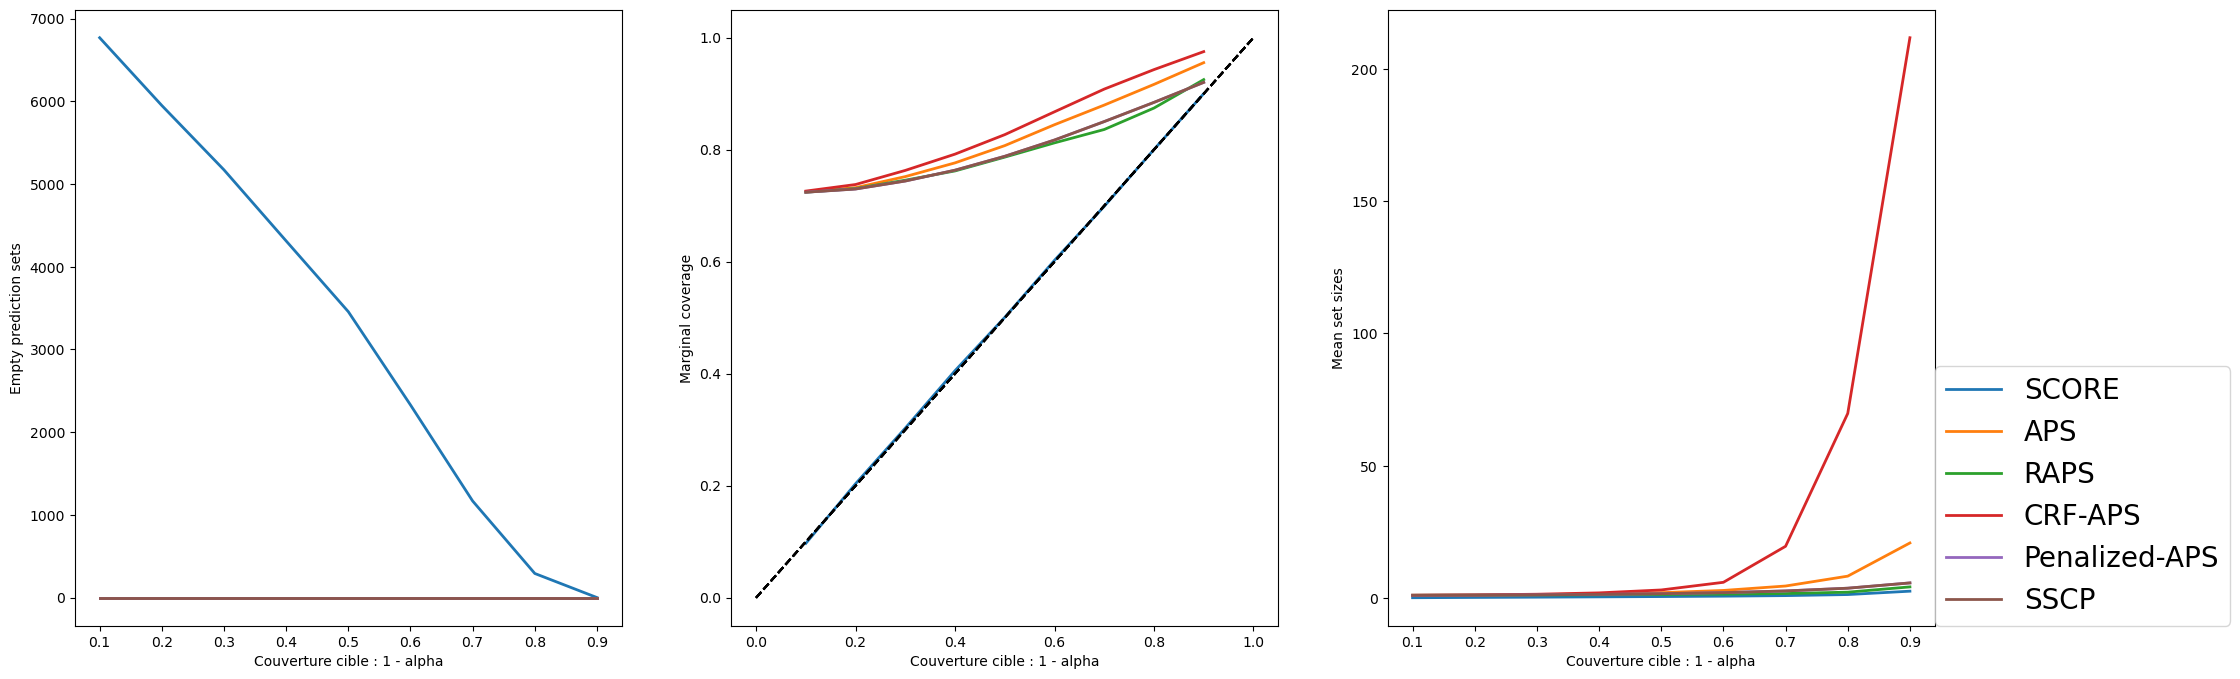

In [104]:
nulls, coverages, mean_sizes = {}, {}, {}

for method_name, (method, _) in method_params.items():
    nulls[method] = [
        count_null_set(pss_dict[method_name][:, :, i])  for i, _ in enumerate(ALPHAS)
    ]
    coverages[method] = [
        classification_coverage_score(
            y_test.astype(int), pss_dict[method_name][:, :, i]
        ) for i, _ in enumerate(ALPHAS)
    ]
    mean_sizes[method] = [
        pss_dict[method_name][:, :, i].sum(axis=1).mean() for i, _ in enumerate(ALPHAS)
    ]

vars_y = [nulls, coverages, mean_sizes]
labels_y = ["Empty prediction sets", "Marginal coverage", "Mean set sizes"]
fig, axs = plt.subplots(1, len(vars_y), figsize=(8*len(vars_y), 8))

for i, var in enumerate(vars_y):
    for method_name, (method, _) in method_params.items():
        axs[i].plot(1 - ALPHAS, var[method], label=method_name, linewidth=2)
        if i == 1:
            axs[i].plot([0, 1], [0, 1], ls="--", color="k")
    axs[i].set_xlabel("Couverture cible : 1 - alpha")
    axs[i].set_ylabel(labels_y[i])
    if i == len(vars_y) - 1:
        axs[i].legend(fontsize=20, loc=[1, 0])

### Distribution des tailles d'ensembles de prédiction

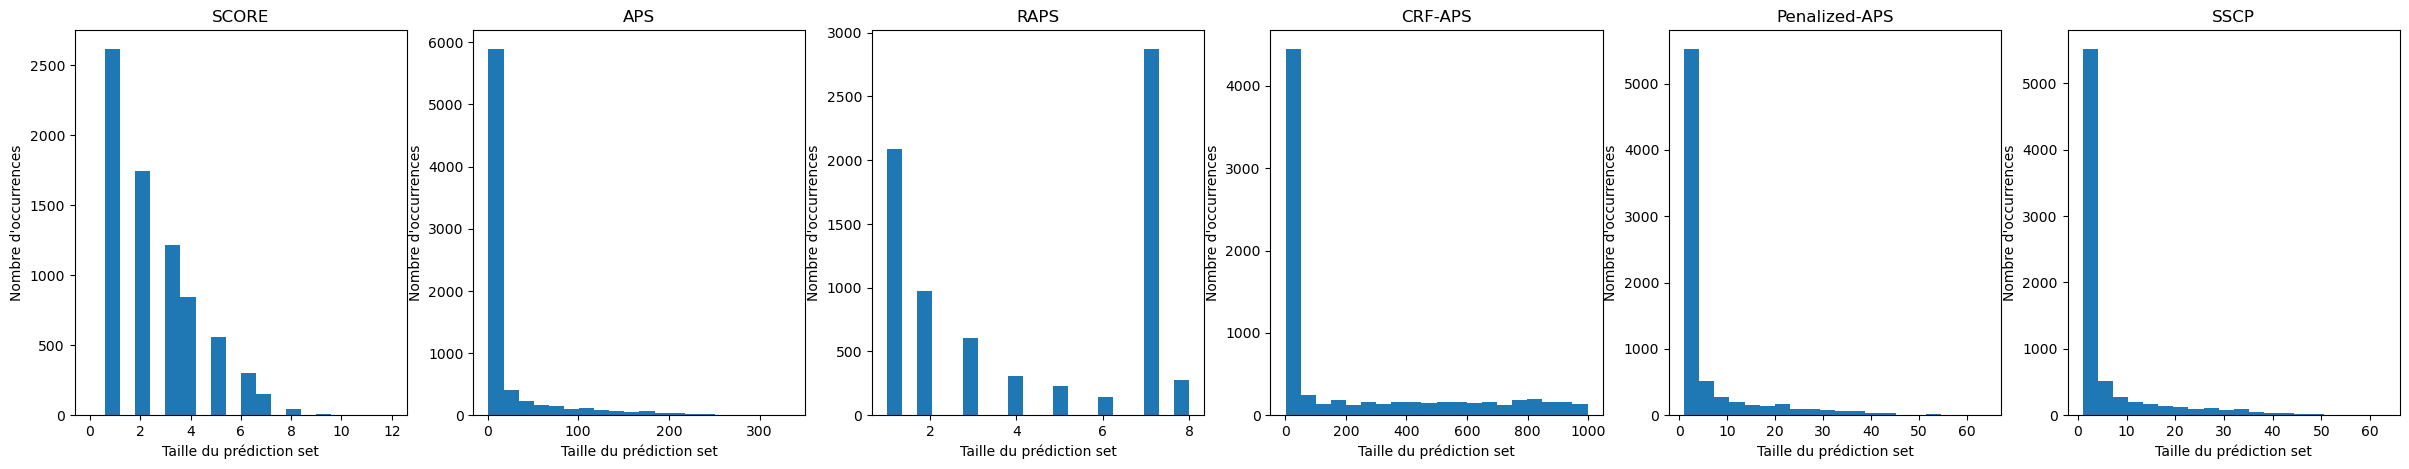

In [105]:
fig, axs = plt.subplots(1, len(method_params), figsize=(5*len(method_params), 5))

for i, method in enumerate(pss_dict):
    pss = pss_dict[method][:, :, 0].sum(axis=1)
    axs[i].hist(pss, bins=20)
    axs[i].set_xlabel("Taille du prédiction set")
    axs[i].set_ylabel("Nombre d'occurrences")
    axs[i].set_title(method)

### Size-stratified Coverage avec fréquence des tailles d'ensembles de prédiction

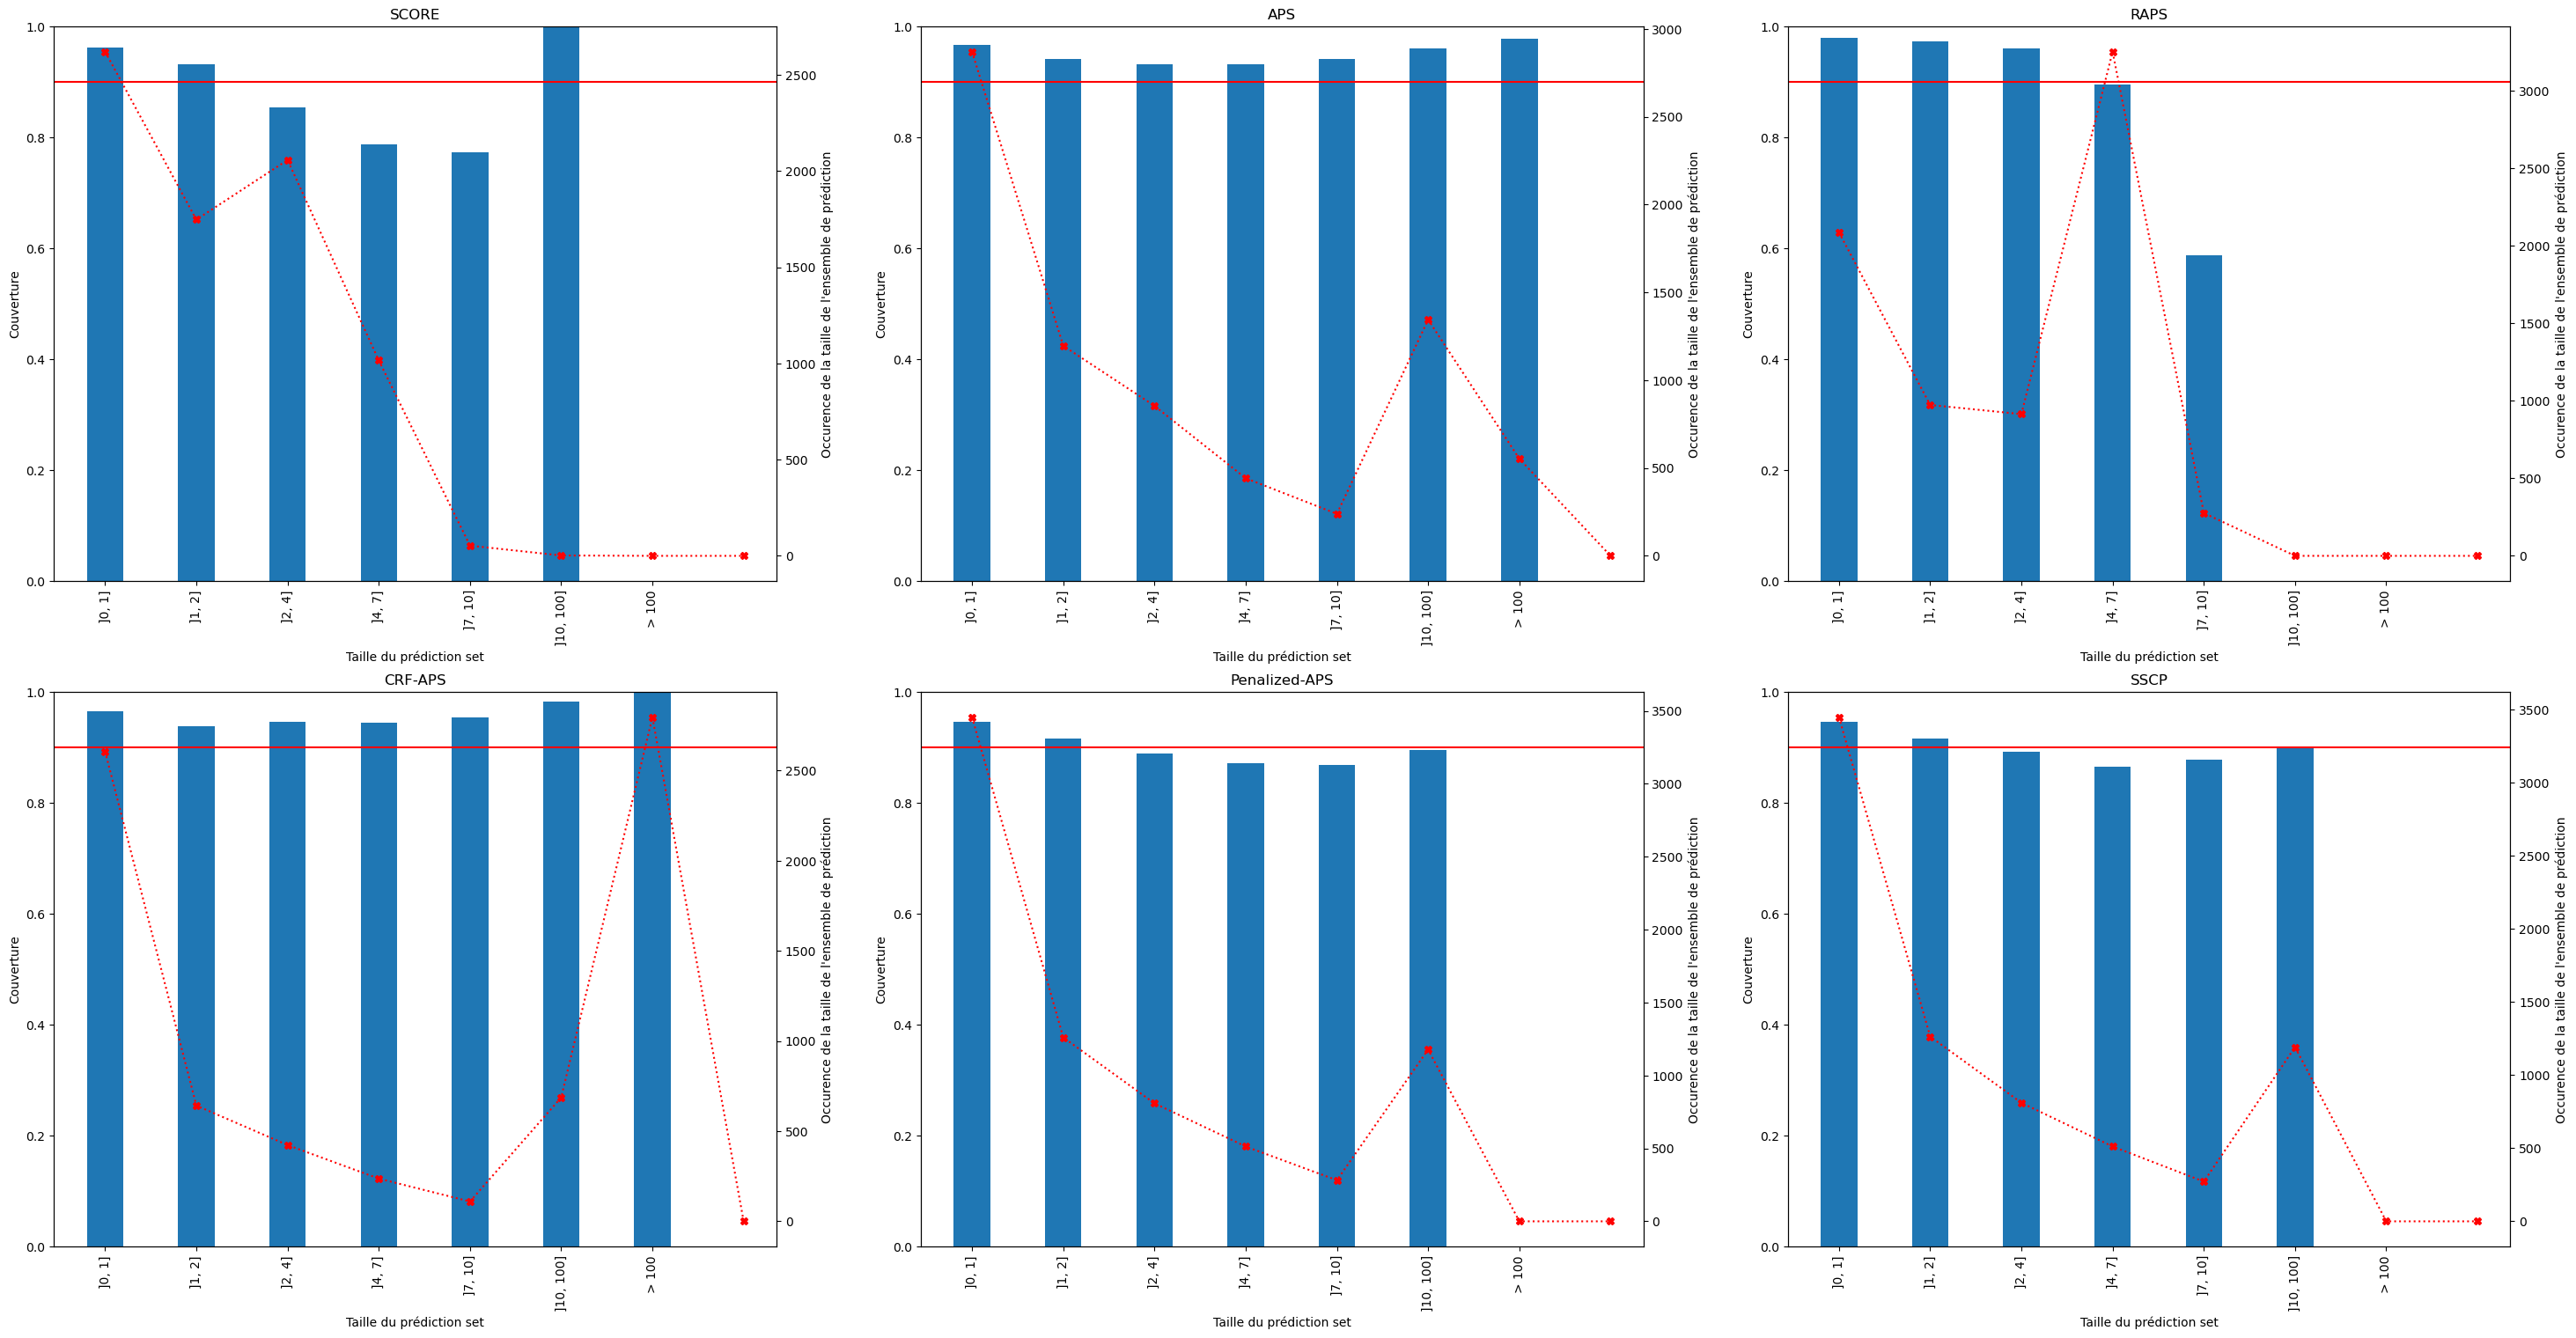

In [106]:
fig, ax1 = plt.subplots(2, 3, figsize=(6*len(method_params), 18))

bins = [0, 1, 2, 4, 7, 10, 100, float('inf')]
x_ticks = [']0, 1]', ']1, 2]', ']2, 4]', ']4, 7]', ']7, 10]', ']10, 100]', '> 100']

for i, method in enumerate(method_params):
    if i < len(method_params)/2:
        clf_ssc, count_stratified = classification_ssc(y_test.astype(int), pss_dict[method], bins=bins)
        ax1[0, i].bar(range(0, len(bins)), clf_ssc[0], width=.4)
        ax1[0, i].set_xticks(range(0, len(bins)-1), x_ticks, rotation='vertical')
        ax1[0, i].set_xlabel("Taille du prédiction set")
        ax1[0, i].set_ylabel("Couverture")
        ax1[0, i].set_ylim(0, 1)
        ax1[0, i].axhline(0.9, color='red')
        ax1[0, i].set_title(method)
        ax2 = ax1[0, i].twinx()
        ax2.plot(range(0, len(bins)), count_stratified[0], 'X:r')
        ax2.set_ylabel("Occurence de la taille de l'ensemble de prédiction")
    else:
        i -= 3
        clf_ssc, count_stratified = classification_ssc(y_test.astype(int), pss_dict[method], bins=bins)
        ax1[1, i].bar(range(0, len(bins)), clf_ssc[0], width=.4)
        ax1[1, i].set_xticks(range(0, len(bins)-1), x_ticks, rotation='vertical')
        ax1[1, i].set_xlabel("Taille du prédiction set")
        ax1[1, i].set_ylabel("Couverture")
        ax1[1, i].set_ylim(0, 1)
        ax1[1, i].axhline(0.9, color='red')
        ax1[1, i].set_title(method)
        ax2 = ax1[1, i].twinx()
        ax2.plot(range(0, len(bins)), count_stratified[0], 'X:r')
        ax2.set_ylabel("Occurence de la taille de l'ensemble de prédiction")
plt.show()

In [ ]:
def SSCCovGap(y_true, y_pred_set, alpha):
    ssc = classification_ssc(y_true, y_pred_set)[0]
    cov_gap = (1 - alpha) - np.nanmean(ssc) 
    return cov_gap